# Grover

Demonstrates amplitude amplification  using a 2-qubit application using z-axis rotations to mark the state (See https://qiskit.org/textbook/ch-algorithms/grover.html).

However, the Qiskit textbook presents a multiple marked circuit for the 3-qubit system which does not demostrate the need to iterate over the Grover operator.

First, a 3-Qubit with no ancilla is presented. 

Then, a technique using ancilla is presented. (See https://arxiv.org/pdf/1903.04359.pdf).  

In [1]:
import numpy as np

from math import ceil, sqrt, log2
from random import randint

from fractions import Fraction

from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
import learn_quantum as lq
from learn_quantum import imag, ket, bra, np_array_to_latex as a_to_l
from IPython.display import Latex
import numpy as np
from numpy import pi, cos, sin, exp, gcd, lcm, pi as π
from qiskit.aqua.circuits import gates

import matplotlib.pyplot as plt



### Setup

Some functions to display the results

In [262]:
split_color=['#C00', '#000', '#000']
def sv(circuit):
    lq.show_state_vector(circuit, split_registers=True, split_color=split_color, integer=False)
    
    
def plot_grover(qc, truncate_size):
       
    ket_format = lq.format_state_vector(lq.execute_state_vector(qc), show_zeros=False)
    x_axis_data = []
    y_axis_data = []
    total = 0
    count = 0
    for k, v in sorted(ket_format.items()):
        v = v.real
        x_axis_data.append(k[:len(k)-truncate_size])
        y_axis_data.append(v)
        total += v
        count += 1

    average = total/count
    fig, axes = plt.subplots(1, 1, figsize=(10,5))

    plt.plot([-1, 8], [average, average], 'r--')
    axes.text(-1.3, average+.03, 'Avg='+str(round(average,2)), color='red')
    plt.grid()

    axes.set_ylim([-1.2, 1.2])
    plt.bar(x_axis_data, y_axis_data)
    
    for i, v in enumerate(y_axis_data):
        axes.text(i, 1,  str(round(v, 2)), color='blue', fontweight='bold', ha='center')
    
    plt.show()

## 2-Qubit Grover using Z gates to mark

In [317]:

oracle_size = 2

oracle = QuantumRegister(oracle_size,'ora')
cr_oracle = ClassicalRegister(oracle_size)

init = QuantumCircuit(oracle)
init.h(oracle)

sv(init)

# mark the stae 10 -- use the z gate to mark
mark = QuantumCircuit(oracle)
mark.z(oracle[0])
mark.cz(oracle[0], oracle[1])

sv(init+mark)

diffusion = QuantumCircuit(oracle)
diffusion.h(oracle)
diffusion.x(oracle)
diffusion.h(oracle[1])
diffusion.cx(oracle[0], oracle[1])
diffusion.h(oracle[1])
diffusion.x(oracle)
diffusion.h(oracle)

sv(init+mark+diffusion)


m = QuantumCircuit(oracle, cr_oracle)

m.measure(oracle, cr_oracle)

answers = lq.execute_simulated(qc+grover+m, 1000)
lq.print_reverse_results(answers, integer=False)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Reversed: [('10', 1000)]


In [318]:
lq.show_me_the_matrix(diffusion, factor_out=False)

<IPython.core.display.Latex object>

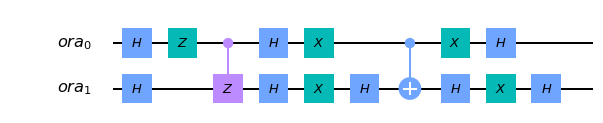

In [321]:
(init+mark+diffusion).draw(output='mpl')

## 3-Qubit no ancilla

In [387]:

oracle = QuantumRegister(3,'ora')
cr_oracle = ClassicalRegister(3)

init = QuantumCircuit(oracle)
init.h(oracle)

sv(init)

mark = QuantumCircuit(oracle)
bits_to_mark='010'

for k in range(len(bits_to_mark)):
     if bits_to_mark[k] == '0':
            mark.x(oracle[k])
mark.h(oracle[2])
mark.ccx(oracle[0], oracle[1], oracle[2])
mark.h(oracle[2])
for k in range(len(bits_to_mark)):
     if bits_to_mark[k] == '0':
            mark.x(oracle[k])        

mark.barrier()

sv(init+mark)

diffusion = QuantumCircuit(oracle)
diffusion.h(oracle)
diffusion.x(oracle)
diffusion.h(oracle[2])
diffusion.ccx(oracle[0], oracle[1], oracle[2])
diffusion.h(oracle[2])
diffusion.x(oracle)
diffusion.h(oracle)

sv(init+mark+diffusion)

m = QuantumCircuit(oracle, cr_oracle)
m.measure(oracle, cr_oracle)

iterations = 3
iteration_qc = init

for i in range(iterations):
    print('Iteration:', i)
    iteration_qc = iteration_qc + mark
    sv(iteration_qc)
    
    iteration_qc = iteration_qc + diffusion
    sv(iteration_qc)
    
    
    answers = lq.execute_simulated(iteration_qc + m, 1000)
    lq.print_reverse_results(answers, integer=False)
    print('----------------------------------')

# answers = lq.execute_simulated(init+mark+diffusion+m, 1000)
# lq.print_reverse_results(answers, integer=False)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Iteration: 0


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Reversed: [('000', 30), ('001', 37), ('010', 773), ('011', 35), ('100', 20), ('101', 32), ('110', 39), ('111', 34)]
----------------------------------
Iteration: 1


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Reversed: [('000', 6), ('001', 11), ('010', 941), ('011', 10), ('100', 13), ('101', 9), ('110', 4), ('111', 6)]
----------------------------------
Iteration: 2


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Reversed: [('000', 99), ('001', 78), ('010', 340), ('011', 87), ('100', 93), ('101', 100), ('110', 108), ('111', 95)]
----------------------------------


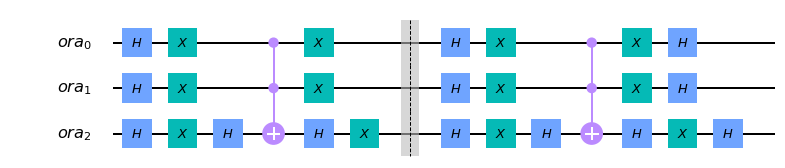

In [377]:
(init+mark+diffusion).draw(output='mpl')

In [384]:
lq.show_me_the_matrix(diffusion)

<IPython.core.display.Latex object>

## Two Qubit Grover (with 1 ancila)

In [389]:
oracle = QuantumRegister(2,'ora')
ancillary = QuantumRegister(1, 'anc')
cr_oracle = ClassicalRegister(2, 'out')

init = QuantumCircuit(oracle, ancillary, cr_oracle)

init.h(oracle)
init.x(ancillary)

sv(init)

mark = QuantumCircuit(oracle, ancillary, cr_oracle)
mark.h(ancillary)
bits_to_mark='01'
for k in range(len(bits_to_mark)):
     if bits_to_mark[k] == '0':
            mark.x(oracle[k])
mark.ccx(oracle[0], oracle[1], ancillary[0])
for k in range(len(bits_to_mark)):
     if bits_to_mark[k] == '0':
            mark.x(oracle[k])
mark.h(ancillary)
mark.barrier()

sv(init+mark)

diffusion = QuantumCircuit(oracle, ancillary, cr_oracle)
diffusion.h(oracle)
diffusion.h(ancillary)
diffusion.x(oracle)
diffusion.ccx(oracle[0], oracle[1], ancillary[0])
diffusion.x(oracle)
diffusion.h(ancillary)
diffusion.h(oracle)

sv(init+mark+diffusion)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

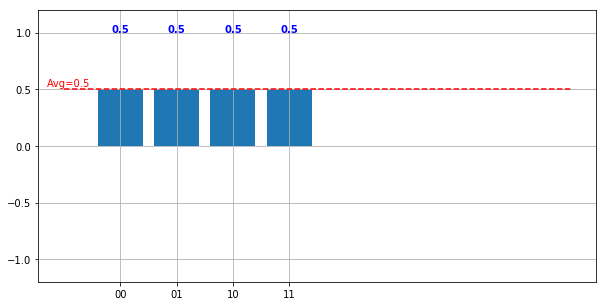

In [390]:
plot_grover(init, 1)

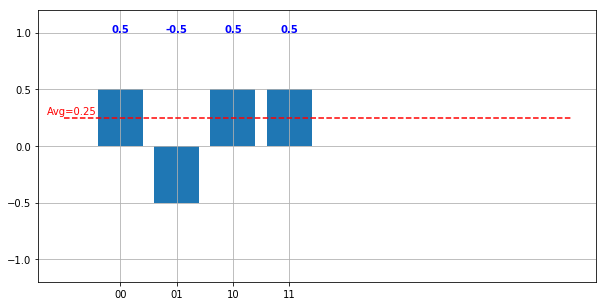

In [391]:
plot_grover(init+mark, 1)

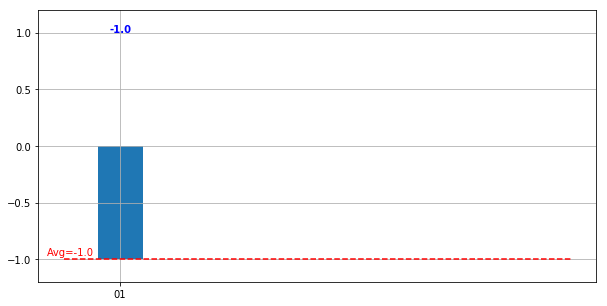

In [393]:
plot_grover(init+mark+diffusion, 1)


## Functions for 3-qubit Grovers

In [299]:
def cccx(qc, qr, an1, an2, mode='basic'):
    if mode == 'noancilla':
        qc.mct([qr[0], qr[1], qr[2]], an1[0], None, mode='noancilla')
        return
    
    qc.ccx(qr[0], qr[1], an2[0])
    qc.ccx(qr[2], an2[0], an1[0])
    qc.ccx(qr[0], qr[1], an2[0])
    
    
def grover_diffusion(qc, qr, an1, an2):
    qc.h(qr)
    qc.h(an1)
    qc.x(qr)
    cccx(qc, qr, an1, an2)
    qc.x(qr)
    qc.h(an1)
    qc.h(qr)
    
    
def mark_phase(qc, qr, an1, an2, bits_to_mark):
    qc.h(an1)
    for k in range(len(bits_to_mark)):
        if bits_to_mark[k] == '0':
            qc.x(qr[k])
    
    cccx(qc, qr, an1, an2)
    for k in range(len(bits_to_mark)):
        if bits_to_mark[k] == '0':
            qc.x(qr[k])
    
    qc.h(an1)
    qc.barrier()


In [422]:
q = QuantumRegister(3,'compute')
anc1 = QuantumRegister(1, 'anc1')
anc2 = QuantumRegister(1,'anc2')
init = QuantumCircuit(q, anc1, anc2)
cr = ClassicalRegister(3)

init.h(q)
init.x(anc1)
sv(init)

mark = QuantumCircuit(q, anc1, anc2)
mark_phase(mark, q, anc1, anc2, '101')

diffusion = QuantumCircuit(q, anc1, anc2)
grover_diffusion(diffusion, q, anc1, anc2)

m = QuantumCircuit(q, anc1, anc2, cr)
m.measure(q, cr)

iterations = 3

iteration_qc = init

for i in range(iterations):
    print('Iteration:', i)
    iteration_qc = iteration_qc + mark
    sv(iteration_qc)
    lq.print_short_state_vector(iteration_qc)
    iteration_qc = iteration_qc + diffusion
    sv(iteration_qc)
    
    
    answers = lq.execute_simulated(iteration_qc + m, 1000)
    lq.print_reverse_results(answers, integer=False)
    print('----------------------------------')


<IPython.core.display.Latex object>

Iteration: 0


<IPython.core.display.Latex object>

0.35355339059327384|00010> 
0.3535533905932738|10010> 
0.3535533905932738|01010> 
0.35355339059327373|11010> 
0.3535533905932738|00110> 
-0.35355339059327373|10110> 
0.35355339059327373|01110> 
0.3535533905932737|11110> 


<IPython.core.display.Latex object>

Reversed: [('000', 36), ('001', 24), ('010', 36), ('011', 28), ('100', 41), ('101', 771), ('110', 33), ('111', 31)]
----------------------------------
Iteration: 1


<IPython.core.display.Latex object>

-0.17677669529663695|00010> 
-0.17677669529663687|10010> 
-0.17677669529663692|01010> 
-0.17677669529663687|11010> 
-0.17677669529663698|00110> 
0.8838834764831842|10110> 
-0.17677669529663687|01110> 
-0.17677669529663684|11110> 


<IPython.core.display.Latex object>

Reversed: [('000', 5), ('001', 10), ('010', 7), ('011', 8), ('100', 8), ('101', 948), ('110', 6), ('111', 8)]
----------------------------------
Iteration: 2


<IPython.core.display.Latex object>

-0.08838834764831838|00010> 
-0.08838834764831817|10010> 
-0.08838834764831846|01010> 
-0.08838834764831835|11010> 
-0.08838834764831838|00110> 
-0.9722718241315026|10110> 
-0.08838834764831832|01110> 
-0.08838834764831835|11110> 


<IPython.core.display.Latex object>

Reversed: [('000', 101), ('001', 116), ('010', 96), ('011', 95), ('100', 102), ('101', 300), ('110', 99), ('111', 91)]
----------------------------------


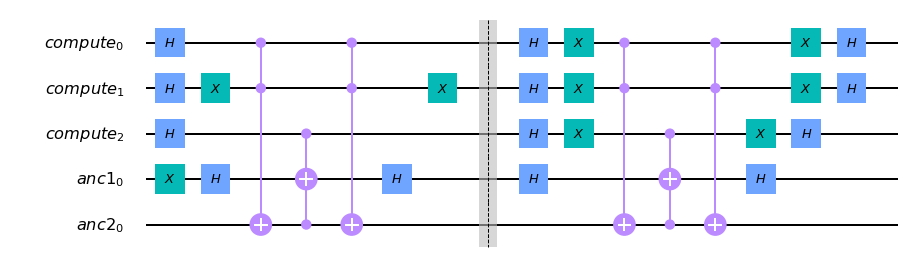

In [423]:
(init+mark+diffusion).draw(output='mpl')

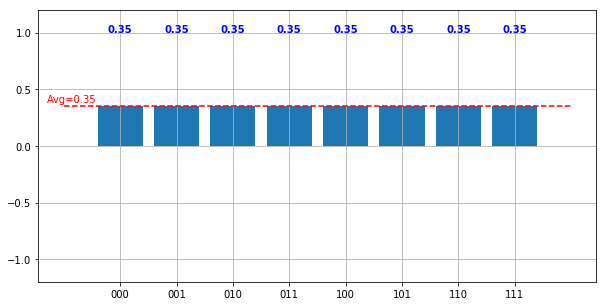

In [425]:
plot_grover(init, 2)

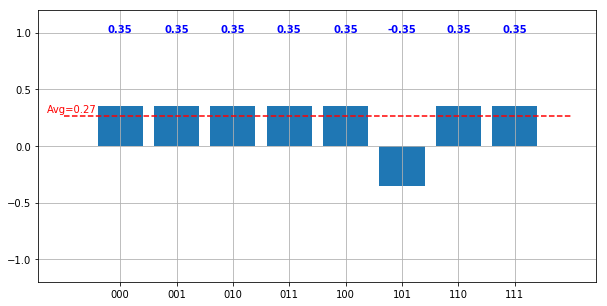

In [426]:
plot_grover(init+mark, 2)

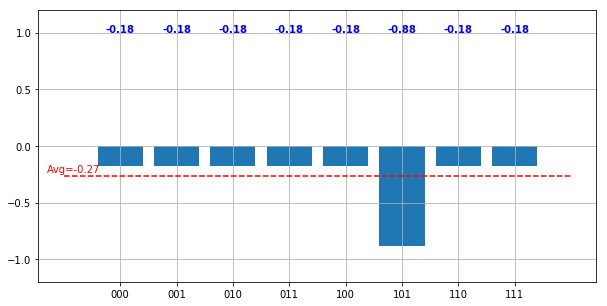

In [427]:
plot_grover(init+mark+diffusion, 2)

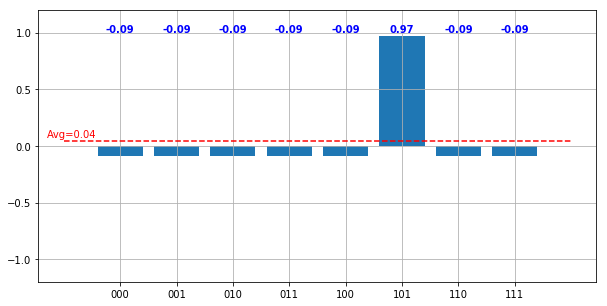

In [428]:
plot_grover(init+mark+diffusion+mark+diffusion, 2)

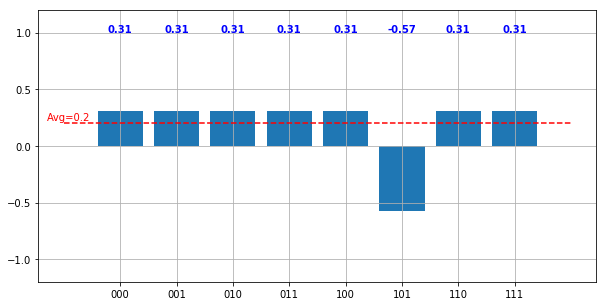

In [429]:
plot_grover(init+mark+diffusion+mark+diffusion+mark+diffusion, 2)

## Exercise: Rotation about the average?

Create a circuit that does not have an initial uniform distribution and show that the diffusion operator does not reflect across the average.

Hint: This can be accomplished by adding a single line to the 3-Qubit Grover routine, but more elaborate setups will work as well.


## Exercise: 8-Qubit Circuit. 

Create an 8-qubit circuit by using the Multiple Control Toffoli (mct) gate.  Write both one with ancilla and one without.  Try running them on a quantum computer and compare the results.